# Train Model

Text

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor

## Define Functions

In [2]:
def to_rolling(dataframe, window=90):
    """
    Converts the data in a given dataframe to a rolling minimum with a default window
    of 84 units, grouped by time and averaged within each group.

    Parameters:
    - dataframe: The input dataframe to be processed. 
      It must contain a 'time' column to group by and perform rolling operations.

    Returns:
    - A tuple where the first element is a dataframe (X)
      containing all columns except the last one, after rolling and dropping NA values, 
      and the second element is a series (y) containing the last column.
    """
    # Make a copy of the dataframe to avoid modifying the original data
    df = dataframe.copy()

    # Group by the time column and set it as the index
    df = df.groupby('time').mean().reset_index()
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Apply a rolling minimum
    df_rolling = df.rolling(window).min().dropna()

    # Select features and the target variable
    X = df_rolling.iloc[:, 2:-1]
    y = df_rolling.iloc[:, -1]

    return X, y


In [3]:
def compute_metrics(X, y, model):
    """
    Computes mean squared error and R-squared metrics.

    Parameters:
    - X: A pandas DataFrame or numpy array containing the features.
    - y: A pandas Series or numpy array containing the target variable.
    - model: A trained model that implements the predict method.

    Returns:
    - A tuple containing the mean squared error and R-squared value.
    """
    # Use the model to predict the target variable
    pred = model.predict(X)
    
    # Calculate mean squared error and R-squared
    mse = mean_squared_error(y, pred)
    rr = r2_score(y, pred)
    
    return mse, rr


In [4]:
def compute_spatial_metrics(dataframe, model):
    """
    Computes mean squared error and R-squared metrics for unique geographic coordinates
    in the dataframe, using predictions from a given model.

    Parameters:
    - dataframe: A pandas DataFrame with latitude and longitude columns as the first two columns,
                 followed by features and the target variable.
    - model: A trained model that implements the predict method.

    Returns:
    - A pandas DataFrame with columns for latitude, longitude, mean squared error, and R-squared,
      one row per unique latitude-longitude pair.
    """
    # Extract unique coordinate pairs from the dataframe
    coords = dataframe.iloc[:, :2].drop_duplicates()
    lats = coords['lat'].to_list()
    lons = coords['lon'].to_list()

    mses = []  # List to store mean squared errors
    rrs = []   # List to store R-squared values
    
    # Iterate over each unique coordinate pair
    for lat, lon in zip(lats, lons):
        # Filter dataframe for the current coordinate pair
        df = dataframe[(dataframe['lat'] == lat) & (dataframe['lon'] == lon)]
        
        # Separate features and target variable
        X = df.iloc[:, 3:-1]
        y = df.iloc[:, -1]
        
        # Predict and calculate metrics
        preds = model.predict(X)
        mse = mean_squared_error(y, preds).round(3)
        rr = r2_score(y, preds).round(3)
        
        # Append metrics to their respective lists
        mses.append(mse)
        rrs.append(rr)

    # Construct the results dataframe
    results = pd.DataFrame({'lat': lats, 'lon': lons, 'mse': mses, 'rr': rrs})
    
    return results


In [5]:
def compute_temporal_metrics(dataframe, model):
    """
    Computes mean squared error and R-squared for unique dates in the dataframe, 
    using predictions from a given model.

    Parameters:
    - dataframe: A pandas DataFrame with a 'time' column as the third column,
                 followed by features and the target variable as the last column.
    - model: A trained model capable of making predictions with the predict method.

    Returns:
    - A pandas DataFrame indexed by date, with columns for mean squared error ('mse')
      and R-squared ('rr'), one row per unique date.
    """
    # Extract unique dates from the dataframe
    dates = dataframe.iloc[:, 2].drop_duplicates()

    mses = []  # List to store mean squared errors
    rrs = []   # List to store R-squared values
    
    # Iterate over each unique date
    for date in dates:
        # Filter dataframe for the current date
        df = dataframe[dataframe['time'] == date]
        
        # Separate features and target variable
        X = df.iloc[:, 3:-1]
        y = df.iloc[:, -1]
        
        # Predict and calculate metrics
        preds = model.predict(X)
        mse = mean_squared_error(y, preds).round(3)
        rr = r2_score(y, preds).round(3)
        
        # Append metrics to their respective lists
        mses.append(mse)
        rrs.append(rr)
    
    # Construct and return the results dataframe
    results = pd.DataFrame({'mse': mses, 'rr': rrs}, index=dates.to_list()).rename_axis('date')
    
    return results


In [6]:
def plot_predictions(y_train, y_validate, x_validate, model):
    """
    Plots the training data, validation data, and predictions from the model.

    Parameters:
    - y_train: Pandas Series containing the actual values for the training set.
    - y_validate: Pandas Series containing the actual values for the validation set.
    - x_validate: Pandas DataFrame or Series containing the features for the validation set.
    - model: A trained model that implements the predict method.
    """
    fig, ax = plt.subplots(figsize=(12, 2))
    # Plot actuals
    y_train.plot(ax=ax)
    y_validate.plot(ax=ax)
    
    # Generate and plot predictions
    y_pred = model.predict(x_validate)
    pd.Series(data=y_pred, index=y_validate.index).plot(ax=ax, label='Predictions', linestyle='--')
    
    # Enhance plot readability
    ax.set_title('Actuals vs. Predictions')
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.legend()
    
    plt.show()

## Define Variables

In [7]:
# Load train dataframe
df_train = pd.read_parquet('../data/processed/df_easternmountain_train.parquet.gzip')
df_train['time'] = pd.to_datetime(df_train['time'])

# Define inputs, outputs, and labels
X_train = df_train.iloc[:, 3:-1]
y_train = df_train.iloc[:, -1]
coords_train = df_train.iloc[:, :2]
time_train = df_train.iloc[:, 2]
model_scenario_train = X_train.columns

# Define rolling inputs, outputs, and labels
X_train_rolling, y_train_rolling = to_rolling(df_train, window=90)

In [8]:
# Load validate dataframe
df_validate = pd.read_parquet('../data/processed/df_easternmountain_validate.parquet.gzip')
df_validate['time'] = pd.to_datetime(df_validate['time'])

# Define inputs, outputs, and labels
X_validate = df_validate.iloc[:, 3:-1]
y_validate = df_validate.iloc[:, -1]
coords_validate = df_validate.iloc[:, :2]
time_validate = df_validate.iloc[:, 2]
model_scenario_validate = df_validate.columns

# Define rolling inputs, outputs, and labels
df_concat = pd.concat((df_train, df_validate))
df_concat = df_concat[df_concat['time'] > pd.to_datetime('2021-10-2')]
X_validate_rolling, y_validate_rolling = to_rolling(df_concat, window=90)

## Explore Data

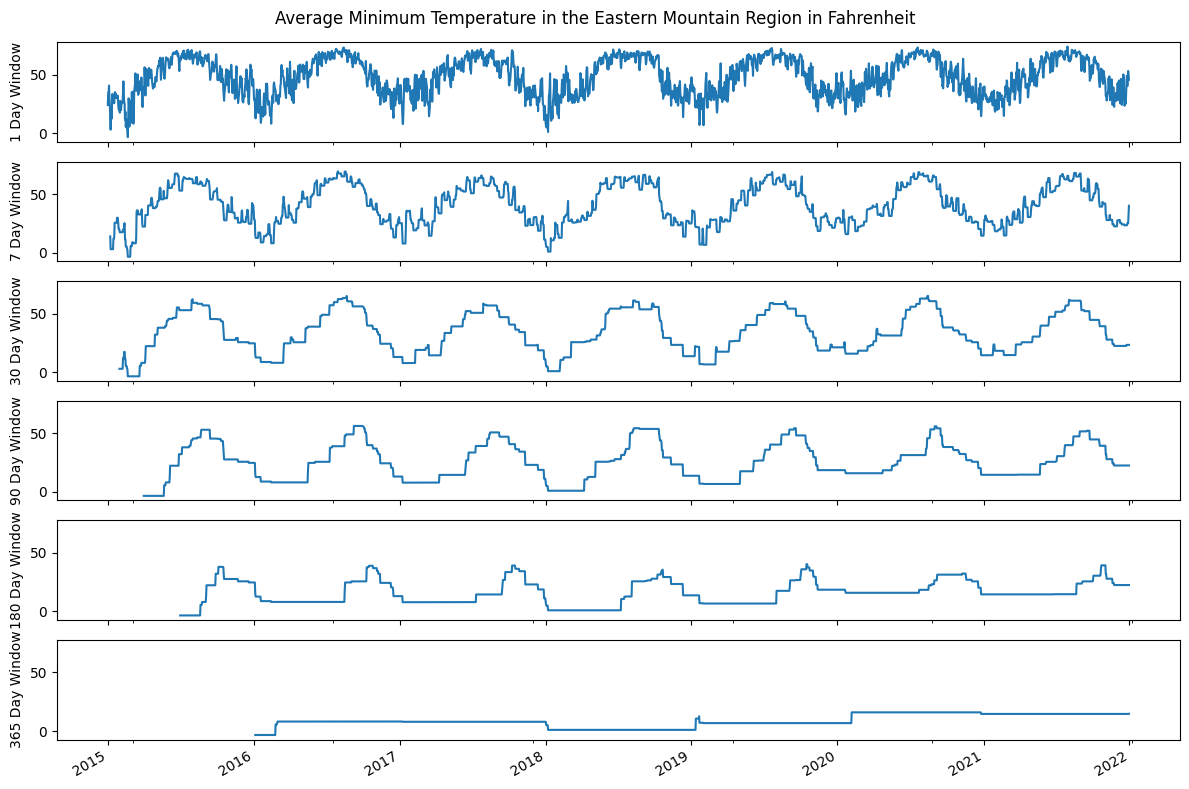

In [9]:
# Plot the average minimum temperature in the Eastern Mountain region for several rolling windows
data = df_train.groupby('time').mean().iloc[:, -1].reset_index()
data['time'] = pd.to_datetime(data['time'])

windows = [1, 7, 30, 90, 180, 365]

fig, axs = plt.subplots(
    nrows=len(windows), 
    ncols=1, 
    figsize=(12, 8), 
    sharex=True, 
    sharey=True, 
    tight_layout=True,
)

for i, window in enumerate(windows):
    data.set_index('time').rolling(window).min().plot(ax=axs[i], legend=False, xlabel='', ylabel=f'{window} Day Window')

fig.suptitle('Average Minimum Temperature in the Eastern Mountain Region in Fahrenheit')

plt.show()

## Train Models

### Establish Baseline

In [10]:
# Average train dataframe across models and scenarios
train_mse = mean_squared_error(y_train, X_train.mean(axis=1))
train_r2 = r2_score(y_train, X_train.mean(axis=1))
print('Train Baseline MSE:', f'{train_mse.round(2)}')
print('Train Baseline R2:', f'{train_r2.round(2)}')

# Average validate dataframe across models and scenarios
validate_mse = mean_squared_error(y_validate, X_validate.mean(axis=1))
validate_r2 = r2_score(y_validate, X_validate.mean(axis=1))
print('Validate Baseline MSE:', f'{validate_mse.round(2)}')
print('Validate Baseline R2:', f'{validate_r2.round(2)}')

Train Baseline MSE: 72.5
Train Baseline R2: 0.71
Validate Baseline MSE: 73.16
Validate Baseline R2: 0.74


In [11]:
# Average rolling train dataframe across models and scenarios
train_mse = mean_squared_error(y_train_rolling, X_train_rolling.mean(axis=1))
train_r2 = r2_score(y_train_rolling, X_train_rolling.mean(axis=1))
print('Train Baseline MSE:', f'{train_mse.round(2)}')
print('Train Baseline R2:', f'{train_r2.round(2)}')

# Average rolling validate dataframe across models and scenarios
validate_mse = mean_squared_error(y_validate_rolling, X_validate_rolling.mean(axis=1))
validate_r2 = r2_score(y_validate_rolling, X_validate_rolling.mean(axis=1))
print('Validate Baseline MSE:', f'{validate_mse.round(2)}')
print('Validate Baseline R2:', f'{validate_r2.round(2)}')

Train Baseline MSE: 64.09
Train Baseline R2: 0.73
Validate Baseline MSE: 32.54
Validate Baseline R2: 0.87


### Ordinary Least Squares Regression (OLS)

Ordinary least squares is less effective than the baseline, with a higher mean squared error (81.572 vs. 73.16) and a lower R-squred value (0.706 vs. 0.740). In addition, mean squared error increases substantially in winter months.

In [12]:
# Train model
ols = LinearRegression().fit(X_train, y_train)

# Assess performance 
train_mse, train_rr = compute_metrics(X_train, y_train, ols)
validate_mse, validate_rr = compute_metrics(X_validate, y_validate, ols)
print('Train MSE:', train_mse.round(3))
print('Train R2:', train_rr.round(3))
print('Validate MSE:', validate_mse.round(3))
print('Validate R2:', validate_rr.round(3))

Train MSE: 61.95
Train R2: 0.756
Validate MSE: 81.572
Validate R2: 0.706


In [13]:
# Train model with rolling data
ols_rolling = LinearRegression().fit(X_train_rolling, y_train_rolling)

# Assess performance with rolling data
train_mse, train_rr = compute_metrics(X_train_rolling, y_train_rolling, ols_rolling)
validate_mse, validate_rr = compute_metrics(X_validate_rolling, y_validate_rolling, ols_rolling)
print('Train MSE:', train_mse.round(3))
print('Train R2:', train_rr.round(3))
print('Validate MSE:', validate_mse.round(3))
print('Validate R2:', validate_rr.round(3))

Train MSE: 9.041
Train R2: 0.962
Validate MSE: 36.311
Validate R2: 0.855


### Elastic-Net Regression

In [15]:
# Train model
eln = ElasticNet(alpha=1.0, max_iter=10000, random_state=42).fit(X_train, y_train)

# Assess performance
train_mse, train_rr = compute_metrics(X_train, y_train, eln)
validate_mse, validate_rr = compute_metrics(X_validate, y_validate, eln)
print('Train MSE:', train_mse.round(3))
print('Train R2:', train_rr.round(3))
print('Validate MSE:', validate_mse.round(3))
print('Validate R2:', validate_rr.round(3))

Train MSE: 62.094
Train R2: 0.756
Validate MSE: 80.299
Validate R2: 0.711


In [17]:
# Train model with rolling data
eln_rolling = ElasticNet(alpha=1.0, max_iter=10000, random_state=42).fit(X_train_rolling, y_train_rolling)

# Assess performance with rolling data
train_mse, train_rr = compute_metrics(X_train_rolling, y_train_rolling, eln_rolling)
validate_mse, validate_rr = compute_metrics(X_validate_rolling, y_validate_rolling, eln_rolling)
print('Train MSE:', train_mse.round(3))
print('Train R2:', train_rr.round(3))
print('Validate MSE:', validate_mse.round(3))
print('Validate R2:', validate_rr.round(3))

Train MSE: 9.917
Train R2: 0.959
Validate MSE: 27.133
Validate R2: 0.892


Want a function that takes in a train dataframe, a validate dataframe, pulls out a specific point, trains a model, calculates statistics, and returns a result.

In [ ]:
def train_spatial_models(df_train, df_validate, model):
    coords = df_train.iloc[:, :2].drop_duplicates()
    lats = coords['lat'].to_list()
    lons = coords['lon'].to_list()

    for lat, lon in zip(lats, lons):
            # Filter dataframe for the current coordinate pair
            df = dataframe[(dataframe['lat'] == lat) & (dataframe['lon'] == lon)]
            
            # Separate features and target variable
            X = df.iloc[:, 3:-1]
            y = df.iloc[:, -1]
            
            # Predict and calculate metrics
            preds = model.predict(X)

    

Explore rolling periods? Minimizes day-to-day variation. 
Explore points?
Explore month and week features? Location features?
Visualize data?

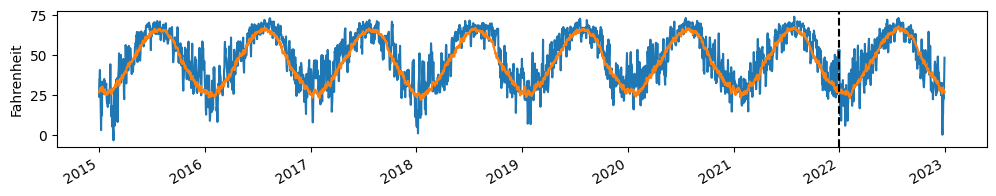

In [ ]:
# Plot average across models and scenarios against actuals
data = pd.concat([df_train, df_validate]).groupby('time').mean().reset_index()
data['time'] = pd.to_datetime(data['time'])

fig, ax = plt.subplots(figsize=(12, 2))
data.set_index('time').iloc[:, -1].plot(ax=ax, legend=False, xlabel='', ylabel='Fahrenheit')
data.set_index('time').iloc[:, 3:-1].mean(axis=1).plot(ax=ax, legend=False, xlabel='', ylabel='Fahrenheit')
plt.axvline(x=pd.to_datetime('2022-01-01'), color='black', linestyle='--')
plt.show()